# Use transfer-learning with huggingface-transformers library

## Load data and make it accessible for huggingface environment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import transformers
from transformers import (AutoTokenizer, 
                          TFAutoModel,
                          TFAutoModelForSequenceClassification
                          )
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset # to use huggingface datasets
from detector.utils import load_data, divide_frame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks, Model
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from joblib import dump, load

transformers.utils.logging.set_verbosity_error()

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [452]:
# Load gpt3 outputs
gpt_simple = load_dataset('aadityaubhat/GPT-wiki-intro')
gpt_simple.set_format(type='pandas')
df_gpt3 = pd.DataFrame(columns=['text', 'AI'])
df_gpt3['text'] = gpt_simple['train']['generated_intro']
df_gpt3['AI'] = 1
df_gpt3["version"] = "gpt3"
df_gpt3.to_csv("gpt3_output/gpt3_simple.csv", index=False)
df_gpt3.reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


,text,AI,version
0,Sexhow railway station was a railway station l...,1,gpt3
1,"In Finnish folklore, all places and things, an...",1,gpt3
2,"In mathematics, specifically differential calc...",1,gpt3
3,is a Japanese shōjo manga series written and i...,1,gpt3
4,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",1,gpt3
...,...,...,...
149995,Randy Borum is a Professor and Coordinator of ...,1,gpt3
149996,"Sa'och (, also, ""Sauch"") is an endangered, nuc...",1,gpt3
149997,Philip C. Hanawalt (born 1931) is an American ...,1,gpt3
149998,Vossius Gymnasium is a public gymnasium in the...,1,gpt3


In [453]:
df_gpt3_advanced = pd.read_csv("gpt3_output/gpt3_advanced.csv")

In [454]:
df_gpt3_advanced["version"] = "gpt3.5"
df_gpt3_advanced

,text,AI,version
0,Washington D.C. - In the midst of a polarizing...,1,gpt3.5
1,Science: The Key to Our Future\n\nScience has ...,1,gpt3.5
2,Local High School Wins State Championship in B...,1,gpt3.5
3,Mathematics: More Than Just Numbers\n\nMathema...,1,gpt3.5
4,Tragic Car Accident Claims Three Lives\n\nIn a...,1,gpt3.5
...,...,...,...
23649,The educational system of Germany\n\nGermany i...,1,gpt3.5
23650,The educational system in Finland is often tou...,1,gpt3.5
23651,Education is an essential aspect of any societ...,1,gpt3.5
23652,The educational system of Germany is one of th...,1,gpt3.5


In [387]:
data = load_data()

In [465]:
train, val, test = (data["train"].reset_index(drop=True), 
                    data["valid"].reset_index(drop=True), 
                    data["test"].reset_index(drop=True))


def remove_newline(text: str) -> str:
    return text.replace("\n", " ")

for df in [train, val, test]:
    df["version"] = np.where(df["AI"] ==1, "gpt2", "human")
    
for df in [train, val, test, df_gpt3, df_gpt3_advanced]:
    df["text"] = df["text"].apply(remove_newline)
    df["text_length"] = df['text'].apply(len)

In [466]:
df_gpt3_advanced = df_gpt3_advanced.sample(frac=1,random_state=1).reset_index(drop=True)
df_gpt3_advanced

,text,AI,version,text_length
0,"Generative AI, also known as creative AI, is a...",1,gpt3.5,1605
1,Science: Advancements and Discoveries in the F...,1,gpt3.5,2301
2,The education system of Finland is known as on...,1,gpt3.5,1177
3,Sports have been an integral part of human soc...,1,gpt3.5,674
4,Tragic Car Accident Claims Three Lives On Fri...,1,gpt3.5,1071
...,...,...,...,...
23649,Artificial intelligence (AI) has seen tremendo...,1,gpt3.5,661
23650,Title: Local High School Wins State Championsh...,1,gpt3.5,1865
23651,Generative AI Revolutionizes Creative Industri...,1,gpt3.5,1061
23652,Introduction: Education is one of the crucial...,1,gpt3.5,1135


In [467]:
train = pd.concat([train, df_gpt3.iloc[:140_000, :], df_gpt3_advanced.iloc[:-5000,:]])
val = pd.concat([val, df_gpt3.iloc[140_000:145_000,:], df_gpt3_advanced.iloc[-5000:-2500,:]])
test = pd.concat([test, df_gpt3.iloc[145_000:,:], df_gpt3_advanced.iloc[-2500:,:]])

In [468]:
train.version.value_counts()

version
human     250000
gpt2      250000
gpt3      140000
gpt3.5     18654
Name: count, dtype: int64

In [6]:
train_size = 70_000

In [470]:
train_sample = pd.concat(
                    [train[train.version == "human"].sample(n=train_size//2, random_state=1),
                    train[train.version == "gpt2"].sample(n=train_size//8, random_state=1),
                    train[train.version == "gpt3"].sample(n=train_size//8, random_state=1),
                    train[train.version == "gpt3.5"].sample(n=train_size//4, random_state=1)]
                    ).reset_index(drop=True)
val = pd.concat([val[val.version == "human"].sample(5000, random_state=1),
                 val[val.version == "gpt2"].sample(1250, random_state=1),
                 val[val.version == "gpt3"].sample(1250, random_state=1),
                 val[val.version == "gpt3.5"].sample(2500, random_state=1)]).reset_index(drop=True)
test = pd.concat([test[test.version == "human"].sample(5000, random_state=1),
                 test[test.version == "gpt2"].sample(1250, random_state=1),
                 test[test.version == "gpt3"].sample(1250, random_state=1),
                 test[test.version == "gpt3.5"].sample(2500, random_state=1)]).reset_index(drop=True)

In [471]:
display(train_sample)
display(val)
display(test)

,text,AI,version,text_length
0,drereichdude's Thoughts: This is one of my fa...,0,human,1714
1,Duration (Minutes)When current flows through w...,0,human,572
2,# !/usr/bin/env python ''' NAME ghc-coloriz...,0,human,3126
3,I think Azure Logic Apps is a great way to imp...,0,human,4309
4,Recipe for a vegan Falafel Burger with avocado...,0,human,3989
...,...,...,...,...
69995,Machine learning is an exciting field of compu...,1,gpt3.5,1091
69996,Mathematics is a fundamental subject that has ...,1,gpt3.5,716
69997,"Mathematics, often referred to as the language...",1,gpt3.5,2075
69998,Sports have been a fundamental aspect of human...,1,gpt3.5,818


,text,AI,version,text_length
0,"Behold, a virgin shall conceive, and bear a so...",0,human,3807
1,"John Fetterman, center, the mayor of Braddock,...",0,human,4486
2,Who is Alec Torelli? Alec Torelli has a uniqu...,0,human,543
3,The year is 2084. If you somehow survived the ...,0,human,1136
4,"AUSTIN, United States — ""Rejections."" That's w...",0,human,4788
...,...,...,...,...
9995,Opening shot of a computer screen with code ru...,1,gpt3.5,1884
9996,Introduction: Machine learning is a subset of...,1,gpt3.5,1171
9997,Title: The Beauty of Mathematics Opening shot...,1,gpt3.5,1834
9998,Introduction: Machine learning is a field of ...,1,gpt3.5,1131


,text,AI,version,text_length
0,Researchers over at Check Point Security have ...,0,human,2540
1,Glass et al. (1989) reported a 16-year-old boy...,0,human,4196
2,(You may have been directed here from www.ke0o...,0,human,1111
3,This tournament is a 1v1 Joust where everyone ...,0,human,1816
4,"Grand Prize - $100,000 The M-Prize Winner is ...",0,human,309
...,...,...,...,...
9995,Generative AI: The Future of Artificial Intell...,1,gpt3.5,2283
9996,Title: Local High School Takes Home Championsh...,1,gpt3.5,2108
9997,Introduction: Politics is an arena that is fi...,1,gpt3.5,2165
9998,Innovative Education System in Finland Finlan...,1,gpt3.5,2367


In [473]:
val.version.value_counts()

version
human     5000
gpt3.5    2500
gpt2      1250
gpt3      1250
Name: count, dtype: int64

In [407]:
# train_small, train_medium, train_long = divide_frame(train)
# for df in [train_small, train_medium, train_long]:
#     print(df.shape[0])

# train_sample = pd.concat([train_small.sample(20_000, random_state=1), 
#                           train_medium.sample(30_000, random_state=1),
#                           train_long.sample(20_000, random_state=1)]).reset_index(drop=True)

In [474]:
ds_train = Dataset.from_pandas(train_sample, split="train")
ds_val = Dataset.from_pandas(val, split="valid")
ds_test = Dataset.from_pandas(test, split="test")

In [475]:
# pack datasets into a dictionary to tokenize them in parallel
ds_dict = DatasetDict({"train": ds_train, "valid": ds_val, "test": ds_test})

In [476]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
})

In [477]:
ds_dict.save_to_disk(f"preprocessed_data_{train_size}")

In [7]:
ds_dict = load_from_disk(f"preprocessed_data_{train_size}")
ds_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
})

## Create Tokenizer suitable for the model

In [8]:
def model_checkpoint(name: str="distilbert", 
                     large: bool=True,
                     uncased: bool=True) -> str:
    model_ckpt = f'{name}-large' if large else f'{name}-base'
    return f'{model_ckpt}-uncased' if uncased else model_ckpt

model_ckpt = model_checkpoint(name="roberta",large=True, uncased=False)
# define the tokenizer the model was trained with
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
#model_ckpt

In [9]:
tokenizer("this is a test!", return_tensors="tf")

2023-06-25 20:07:15.670406: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-06-25 20:07:15.671630: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-25 20:07:15.671657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-25 20:07:15.672105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-25 20:07:15.673813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[   0, 9226,   16,   10, 1296,  328,    2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [10]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [482]:
# define a tokenize function that tokenizes the text in batches
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [483]:
ds_encoded = ds_dict.map(tokenize, batched=True, batch_size=10_000)

In [484]:
ds_encoded.save_to_disk(f"encoded_data_{train_size}")

In [11]:
ds_encoded = load_from_disk(f"encoded_data_{train_size}")

## Option 1: Use pre-trained model as feature extractor

### Extracting last hidden layer of a BERT model

For this approach the model-weights of our RoBERTA model are frozen and provide features for a classifier 

In [12]:
model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True) # load the model from the checkpoint

In [13]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="tf")
outputs = model(**inputs)
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 6, 1024), dtype=float32, numpy=
array([[[ 0.04603524, -0.00462841,  0.01070017, ..., -0.05166832,
          0.10207281,  0.06168523],
        [ 0.16665468, -0.10331246, -0.35997272, ...,  0.06356603,
         -0.1478664 ,  0.08259304],
        [ 0.36435974, -0.06037583, -0.32145458, ...,  0.09165369,
          0.07294382,  0.12116899],
        [-0.08846132, -0.09831417,  0.01492194, ..., -0.04664286,
         -0.18895282,  0.1724447 ],
        [ 0.07978453, -0.15301354, -0.12229724, ..., -0.16046473,
          0.11752793,  0.00620504],
        [ 0.06696582, -0.0087914 ,  0.03385552, ..., -0.0685569 ,
          0.08994152,  0.01962573]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.15439375,  0.71824986,  0.45034176, ..., -0.00599452,
         0.40904945, -0.3544111 ]], dtype=float32)>, past_key_values=None, hidden_states=None, attentions=None, cross_at

In [14]:
outputs.last_hidden_state.shape #output [batch_size, n_tokens, hidden_dim]

TensorShape([1, 6, 1024])

In [15]:
# for classification it is common practice use hidden state associated to start 
# of sequence token
outputs.last_hidden_state[:, 0].shape 

TensorShape([1, 1024])

In [16]:
# extract last hidden state for whole dataset
def extract_hidden_states(batch):
    inputs = {k: v for k,v in batch.items() if k in tokenizer.model_input_names}
    last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].numpy()}

In [17]:
ds_encoded.set_format("tensorflow", columns=["input_ids", "attention_mask", "AI"])

In [18]:
extract_hidden_states(ds_encoded["train"][:2])

{'hidden_state': array([[-0.3427664 , -0.28302005, -0.21823733, ...,  0.21029028,
         -0.7165592 ,  0.48414364],
        [-0.3774553 , -0.19625072, -0.10798267, ...,  0.48125118,
         -0.23683989,  0.46917036]], dtype=float32)}

In [492]:
ds_hidden = ds_encoded.map(extract_hidden_states, batched=True, batch_size=50)

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [493]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

In [494]:
ds_hidden.save_to_disk(f"hidden_states_{model_ckpt}_{train_size}")

In [19]:
ds_hidden = load_from_disk(f"hidden_states_{model_ckpt}_{train_size}")

In [20]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

-----

### Preparing data to train model

We are now using these hidden states to train a relatively simple classifier to predict if text is AI written or not.

In [21]:
X_train = np.array(ds_hidden["train"]["hidden_state"])
X_val = np.array(ds_hidden["valid"]["hidden_state"])
X_test = np.array(ds_hidden["test"]["hidden_state"])

y_train = np.array(ds_hidden["train"]["AI"])
y_val = np.array(ds_hidden["valid"]["AI"])
y_test = np.array(ds_hidden["test"]["AI"])

In [22]:
X_train

array([[-0.3427664 , -0.28302005, -0.21823733, ...,  0.21029028,
        -0.7165592 ,  0.48414364],
       [-0.3774553 , -0.19625072, -0.10798267, ...,  0.48125118,
        -0.23683989,  0.46917036],
       [-0.39391053,  0.17262237,  0.03629463, ...,  0.2960962 ,
        -0.76028746,  0.70063794],
       ...,
       [-0.23375955, -0.30192906, -0.0972286 , ...,  0.21891847,
        -0.0503808 ,  0.3804766 ],
       [-0.27781478, -0.257085  , -0.10656475, ...,  0.28357393,
        -0.07758123,  0.43826705],
       [-0.48439917, -0.34412006, -0.11208704, ...,  0.58168375,
        -0.5461089 ,  0.54337895]], dtype=float32)

In [23]:
X_train.shape, y_train.shape

((70000, 1024), (70000,))

In [24]:
X_search = np.vstack((X_train, X_val))
y_search = np.hstack((y_train, y_val))

In [25]:
X_search.shape, y_search.shape
split = PredefinedSplit([-1]*X_train.shape[0]+[0]*X_val.shape[0])

In [26]:
scores_model_roberta = {}

### Logistic Regression

In [509]:
lr_clf = LogisticRegression(max_iter=5000)

params = {"C":[2**k for k in range(0, 7)]}

search = GridSearchCV(lr_clf,
                      param_grid=params,
                      n_jobs=-1,
                      cv = split,
                      scoring="accuracy")

In [510]:
search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
             param_grid={'C': [1, 2, 4, 8, 16, 32, 64]}, scoring='accuracy')

In [511]:
search.best_score_

0.964

In [512]:
lr_clf_best = search.best_estimator_

In [513]:
lr_clf_best.fit(X_train, y_train)

LogisticRegression(C=32, max_iter=5000)

In [515]:
dump(lr_clf_best, f"trained_models_{train_size}/lr_clf_best_{model_ckpt}.joblib")

['trained_models_70000/lr_clf_best_roberta-large.joblib']

In [27]:
lr_clf_best = load(f"trained_models_{train_size}/lr_clf_best_{model_ckpt}.joblib")

In [28]:
scores_model_roberta["logistic_regression"] = lr_clf_best.score(X_test, y_test)
scores_model_roberta["logistic_regression"]

0.9624

### SVM Classifier

In [38]:
#from sklearn.svm import SVC

In [39]:
# svc = SVC(random_state=1)

# params_svc = {
#     'C': [0.5, 1, 2],
#     #'degree': 3,
#     'kernel': ['linear']
#  }

# search_svc = GridSearchCV(
#     svc,
#     param_grid=params_svc,
#     n_jobs=-1,
#     cv=split,
#     scoring="accuracy"
# )

In [40]:
# search_svc.fit(X_search, y_search)

In [41]:
# search_svc.best_score_

In [42]:
# svc_best = search_svc.best_estimator_

In [43]:
# svc_best.fit(X_train, y_train)

In [44]:
# svc_best.score(X_test, y_test)

### Random Forest Classifier

In [45]:
#from sklearn.ensemble import RandomForestClassifier

In [46]:
#rf_clf = RandomForestClassifier(random_state=1, verbose=1, n_jobs=-1)

In [47]:
# params_rf = {
#  'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]
#  }

# random_search = RandomizedSearchCV(rf_clf,
#                                    param_distributions=params_rf,
#                                    n_iter=5,
#                                    scoring="accuracy",
#                                    n_jobs=-1,
#                                    cv=split)

In [85]:
# random_search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features=

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy')

In [48]:
#random_search.best_score_

### Gradient Boosting

In [ ]:
# from xgboost import XGBClassifier
# xgb_clf = XGBClassifier(booster = 'gblinear', 
#                         n_estimators=1000, 
#                         seed=1, 
#                         random_state=1)
# #xgb_clf.get_params()
# params_xgb = {
#     'reg_lambda': [k*0.1 for k in range(15)]
#     }

# search_xgb = GridSearchCV(
#     xgb_clf,
#     param_grid=params_xgb,
#     n_jobs=-1,
#     cv=split,
#     scoring="accuracy"
# )

In [29]:
# search_xgb.fit(X_search, y_search)

In [140]:
# xgb_best = search_xgb.best_estimator_

In [141]:
# xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [142]:
# dump(xgb_best, f"trained_models/xgb_best_{model_ckpt}.joblib.dat")

['trained_models/xgb_best_roberta-large.joblib.dat']

In [143]:
# scores_model_roberta["xgb"] = xgb_best.score(X_test, y_test)

In [144]:
# scores_model_roberta["xgb"]

0.9368

### Ridge Classification

In [30]:
from sklearn.linear_model import RidgeClassifierCV

In [41]:
ridge_clf = RidgeClassifierCV(alphas=[0.03, 0.04, 0.05, 0.06], cv=split)

ridge_clf.fit(X_search, y_search)

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.56558e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.28438e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.00005e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/line

RidgeClassifierCV(alphas=[0.03, 0.04, 0.05, 0.06],
                  cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])))

In [43]:
ridge_clf.best_score_

0.9601

In [44]:
dump(ridge_clf, f"trained_models_{train_size}/ridge_clf_{model_ckpt}.joblib")

['trained_models_70000/ridge_clf_roberta-large.joblib']

In [45]:
scores_model_roberta["ridge"] = ridge_clf.score(X_test, y_test)

In [46]:
scores_model_roberta["ridge"]

0.9591

### Simple NN

In [223]:
nn_inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation='gelu', kernel_initializer="he_normal")(nn_inputs)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='gelu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
nn_model = Model(inputs=nn_inputs, outputs = outputs, name="basic_nn")
nn_model.summary()

Model: "basic_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_52 (Dense)            (None, 64)                65600     
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_114 (Dropout)       (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 69825 (272.75 KB)
Trainable params: 69825 (272.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [224]:
num_epochs = 150
num_train_examples = X_train.shape[0]
batch_size = 32
init_lr = 1e-3

decay_steps = num_train_examples // batch_size

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr,
                                                    decay_steps=decay_steps,
                                                    decay_rate=0.9)

es = callbacks.EarlyStopping(monitor="val_binary_accuracy",
                             mode="max",
                             patience=10,
                             restore_best_weights=True)

nn_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[keras.metrics.BinaryAccuracy()],
                 optimizer = optimizers.Adam(lr_schedule))

In [225]:
history = nn_model.fit(X_train, y_train,
             batch_size=batch_size,
             epochs=num_epochs,
             validation_data=(X_val, y_val),
             callbacks=[es])

Epoch 1/150


/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-24 12:58:31.575438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 0.3850 - binary_accuracy: 0.8239

2023-06-24 12:58:40.424640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step - loss: 0.3847 - binary_accuracy: 0.8241 - val_loss: 0.2960 - val_binary_accuracy: 0.8749
Epoch 2/150
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2679 - binary_accuracy: 0.8838 - val_loss: 0.2898 - val_binary_accuracy: 0.8699
Epoch 3/150
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2353 - binary_accuracy: 0.9006 - val_loss: 0.2055 - val_binary_accuracy: 0.9203
Epoch 4/150
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2166 - binary_accuracy: 0.9092 - val_loss: 0.1917 - val_binary_accuracy: 0.9252
Epoch 5/150
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2047 - binary_accuracy: 0.9136 - val_loss: 0.1854 - val_binary_accuracy: 0.9252
Epoch 6/150
1250/1250 [==============================] - 9s 8ms/step - loss: 0.1877 - binary_accuracy: 0.9216 - val_loss: 0.2131 - val_binary_accuracy: 0.9086
Epoch 7/150
1250/1250 [==============================] 

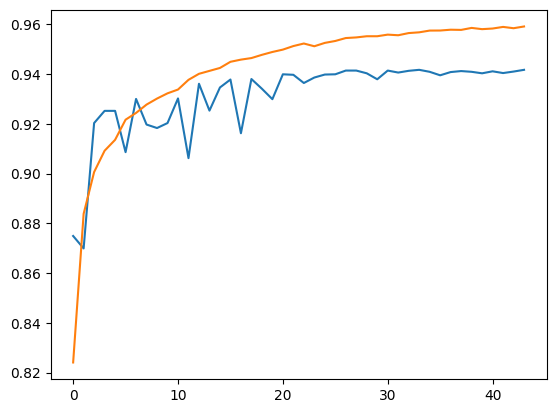

In [226]:
plt.plot(history.history["val_binary_accuracy"])
plt.plot(history.history["binary_accuracy"]);

In [227]:
scores_model_roberta["neural_network"] = nn_model.evaluate(X_test, y_test)[1]
scores_model_roberta["neural_network"]

313/313 [==============================] - 2s 5ms/step - loss: 0.1626 - binary_accuracy: 0.9370


0.9369999766349792

In [228]:
nn_model.save(f"nn_model_{model_ckpt}")

INFO:tensorflow:Assets written to: nn_model_roberta-large/assets


INFO:tensorflow:Assets written to: nn_model_roberta-large/assets


## Get Prediction for input text

In [284]:
test_text = test.loc[9999, "text"]
test_text_gpt3 = '''In recent years, we have witnessed a remarkable revolution in 
the field of artificial intelligence (AI). The rapid advancements in machine learning 
and neural networks have unlocked unprecedented capabilities, enabling AI systems to 
perform complex tasks and mimic human intelligence with remarkable accuracy. 
This revolution has had a profound impact on various aspects of our lives, including 
communication, entertainment, and information dissemination.'''
#nn_model.predict(model(**tokenizer(test_text_gpt3, return_tensors='tf')).last_hidden_state[:,0].numpy())
lr_clf_best.predict_proba(model(**tokenizer(test_text_gpt3, return_tensors='tf')).last_hidden_state[:,0].numpy())[0]

array([0.99881792, 0.00118208])

In [285]:
def get_prediction(text_input: str, 
                   model_ckpt: str="distilbert-base-uncased",
                   model_name: str="nn") -> tuple[float, str]:
    '''outputs the probability of the text being AI written
    ---
    text_input: text to be classified
    ---
    model_ckpt: model to be used for feature extraction. Options are "distilbert"
    and "roberta".
    ---
    model_name: model to be used for classification. Options are "nn" 
    for neural network, "xgb" for xgboost,
    "lr" for logistic regression, "ridge" for ridge classifier.
    '''
    # instantiate tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True)
    # extract features
    inputs = tokenizer(text_input, return_tensors="tf")
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    # choose model for classification and return prediction and probability
    proba = None
    class_pred = None
    if model_name == "nn":
        nn_model = keras.models.load_model(f"nn_model_{model_ckpt}")
        proba = nn_model.predict(hidden_states, verbose=0)[0][0]
    elif model_name == "lr":
        lr_clf_best = load(f"trained_models/lr_clf_best_{model_ckpt}.joblib")
        proba = lr_clf_best.predict_proba(hidden_states)[0][1]
    elif model_name == "ridge":
        ridge_clf = load(f"trained_models/ridge_clf_{model_ckpt}.joblib")
        proba = ridge_clf.decision_function(hidden_states)[0]
    elif model_name == "xgb":
        xgb_best = load(f"trained_models/xgb_best_{model_ckpt}.joblib.dat")
        proba = xgb_best.predict_proba(hidden_states)[0][1]
    else:
        raise ValueError("model must be one of 'nn', 'lr' or 'ridge'")
    if proba > 0.5:
        class_pred = "AI written"
    else:
        class_pred = "not AI written"
    print(f'''Probability of text being AI written: {proba:.2f}
The prediction therfore is that the text is {class_pred}''')
    return proba, class_pred

In [320]:
get_prediction(test_text, model_ckpt="roberta-large", 
               model_name="lr")

Probability of text being AI written: 1.00
The prediction therfore is that the text is AI written


(0.9996794928047869, 'AI written')